In [1]:
#biblioteca para geolocalizar os tweets
#pip install geopy

     |████████████████████████████████| 118 kB 880 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [22]:
#pip install Yellowbrick

     |████████████████████████████████| 282 kB 1.3 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
#Modelagem de dados
import pandas as pd
import numpy as np

#Gráficos
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

#Avisos
import warnings
warnings.filterwarnings('ignore')

#Configurações
pd.set_option('display.max_rows',200)
pd.set_option('display.max_columns',100)

plt.rcParams['figure.figsize'] = (12,6)
plt.style.use('seaborn-darkgrid')

#extra libs
import re  #Regex
import nltk #NLP


# Projeto baseado no curso Anális de mineração de texto + Classificação de emoção (NLP)

## Esse código será aplicado para tweets. Cada tweet tem como conteúdo:
### --> Postagem: texto[pequenos ou grandes], emojis, abreviações, reclamações

## Inicialmente precisamos limpar o texto: retirar links, hashtags, menções, palavras comuns que não tenham importância para a análise

## Depois vamos usar o modelo Naive Bayes pra classificar os tweets em positivo, negativo e neutro e vamos avaliar os resultados por meio de uma matriz de confusão

## Iremos comparar a performance com outros modelos de classificação

In [2]:
#Lendo a base de dados
Base_dados = pd.read_csv('Tweets_Mg.csv')
#dimensão
Base_dados.shape


(8199, 26)

In [ ]:
Base_dados.head()

# Modelagem e Análise exploratória dos dados

<AxesSubplot:title={'left':'Analisando campos nulos'}>

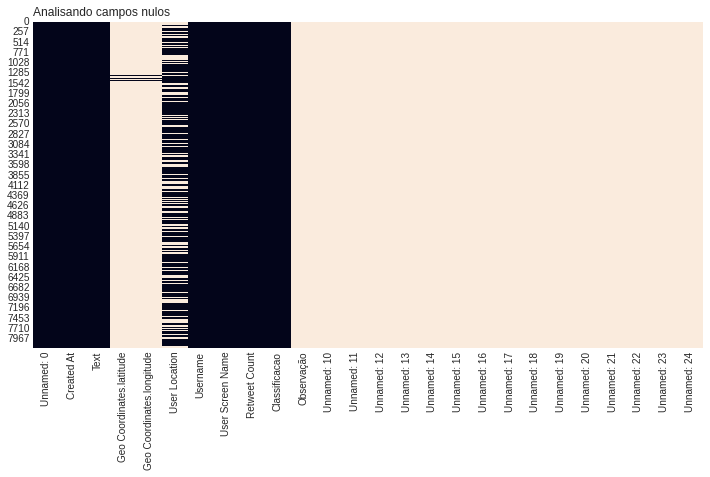

In [3]:
#Para visualisar os dados que são nulos
Nulos = Base_dados.isnull()

plt.title('Analisando campos nulos', loc = 'left')
sns.heatmap(Nulos, cbar = False)


In [ ]:
#colunas
Base_dados.columns

In [4]:
#remover colunas com dados nulos
#Colunas_extrair = Base_dados.columns[10:]
Base_dados.drop(columns = Base_dados.columns[10:], inplace = True)

In [ ]:
Base_dados.shape

In [ ]:
#dados unicos
Base_dados.nunique()

In [5]:
#retirar primeira coluna Unnamed : 0
Base_dados.drop(columns = "Unnamed: 0", inplace = True)

## Ajustando a data


In [ ]:
from dateutil.parser import parse
Experimento_data = Base_dados["Created At"][0]
Experimento_data

In [ ]:
#transformar data
print(f'Depois: {parse(Experimento_data).date()}')

In [ ]:
#função para aplicar o ajuste em toda coluna de dados
def Ajustar_data(Data):
    '''Função para ajustar a data'''
    
    #Atribuir
    Texto_data = Data
    #Transformar
    Transformacao = parse(Texto_data)
    return Transformacao.date()
    

In [ ]:
Base_dados['Data_formatada'] = Base_dados['Created At'].apply(Ajustar_data)

In [ ]:
#outra forma
#Base_dados['Created At'].apply(lambda Text: parse(Text).date())

In [ ]:
#gerando variaveis ano, mes e dia
Base_dados['Data_formatada'] = pd.to_datetime(Base_dados['Data_formatada'])

#extraindo
Base_dados['Ano'] = Base_dados['Data_formatada'].dt.year
Base_dados['Mes'] = Base_dados['Data_formatada'].dt.month
Base_dados['Dia'] = Base_dados['Data_formatada'].dt.day

Base_dados.iloc[0:5, 5:]

In [ ]:
#Analisando
Base_dados.groupby(by = ['Ano','Mes']).agg(
    Quantidade = ('Username','count')
)

# Minerando geolocalização

In [ ]:
Analise_geo = Base_dados.loc[
    (Base_dados['Geo Coordinates.latitude'].notnull()) &
    (Base_dados['Geo Coordinates.longitude'].notnull())
]

In [ ]:
#agrupar as geolocalizações
Analise_localizacao = Analise_geo.groupby(by = ['Geo Coordinates.latitude','Geo Coordinates.longitude']).count()['Username'].reset_index()

#renomeando colunas
Analise_localizacao.columns = ['Lat', 'Lon', 'Qtd']

Analise_localizacao.head()

In [ ]:
#plot dos dados
px.density_mapbox(
    #Dados
    Analise_localizacao,
    #Latitude
    lat = 'Lat',
    lon = 'Lon',
    #Quantidade
    z = 'Qtd',
    #estilo do mapa
    mapbox_style = 'stamen-terrain',
    #Centralização
    center = dict(lat = -23.700, lon = -46.555),
    #Zoom
    zoom = 3,
    #circulo
    radius = 30
    
)

Os dados são incorerentes, provavelmente lat e lon foram coletados errado

In [4]:
from geopy.geocoders import Nominatim

In [6]:
#Instanciando a função
Instanciando_funcao = Nominatim(user_agent = 'GetLoc')

In [ ]:
Instanciando_funcao.geocode('Brasil').address

In [12]:
#analise de representatividade
Analise_local = Base_dados['User Location'].value_counts(normalize = True).cumsum().reset_index()

#Filtrando apenas até 50% das localizações
Analise_local = Analise_local.loc[Analise_local['User Location'] < 0.5]

#Renomear colunas
Analise_local.columns = ['Local', 'Percentual']

#Verificando
Analise_local.head()

Local  Percentual
0                         Brasil    0.107670
1                   Minas Gerais    0.172163
2  Belo Horizonte - Minas Gerais    0.214793
3         Belo Horizonte, Brasil    0.256149
4                 Belo Horizonte    0.280015

In [13]:
#Calcular a quantidade
Quantidade = Base_dados['User Location'].value_counts().reset_index()

Quantidade.columns = ['Local', 'Quantidade']
Quantidade.head()

Local  Quantidade
0                         Brasil         591
1                   Minas Gerais         354
2  Belo Horizonte - Minas Gerais         234
3         Belo Horizonte, Brasil         227
4                 Belo Horizonte         131

In [14]:
Tab_localizacao = pd.merge(Analise_local, Quantidade, on = ['Local'], how = 'inner')

Tab_localizacao.head()

Local  Percentual  Quantidade
0                         Brasil    0.107670         591
1                   Minas Gerais    0.172163         354
2  Belo Horizonte - Minas Gerais    0.214793         234
3         Belo Horizonte, Brasil    0.256149         227
4                 Belo Horizonte    0.280015         131

In [15]:
#Incluindo a geolocalização
Tab_localizacao['Latitude'] = None
Tab_localizacao['Longitude'] = None

#Loop

for loop in range(0, len(Tab_localizacao['Local'])):
    
    try:
        Local = Instanciando_funcao.geocode(Tab_localizacao['Local'][loop])
    except:
        pass
    
    if Local != None:
        Tab_localizacao['Latitude'][loop] = Local.latitude
        Tab_localizacao['Longitude'][loop] = Local.longitude

   

In [16]:
Tab_localizacao.head()

Local  Percentual  Quantidade   Latitude  Longitude
0                         Brasil    0.107670         591 -10.333333      -53.2
1                   Minas Gerais    0.172163         354 -18.526484 -44.158865
2  Belo Horizonte - Minas Gerais    0.214793         234 -19.922732 -43.945095
3         Belo Horizonte, Brasil    0.256149         227 -19.922732 -43.945095
4                 Belo Horizonte    0.280015         131 -19.922732 -43.945095

In [18]:
#plot dos dados
px.density_mapbox(
    #Dados
    Tab_localizacao,
    #Latitude
    lat = 'Latitude',
    lon = 'Longitude',
    #Quantidade
    z = 'Quantidade',
    #estilo do mapa
    mapbox_style = 'stamen-terrain',
    #Centralização
    center = dict(lat = -23.700, lon = -46.555),
    #Zoom
    zoom = 3,
    #circulo
    radius = 30
    
)

## Analise de outras variáveis

In [19]:
Base_dados["Username"].value_counts()

POLÍCIA MILITAR MG      297
Daniel Araujo #beta     124
Hugo TIMBETA            100
Camila Maciel Serrão     91
Raynniere Makepeace      77
                       ... 
Fabiano Vieira            1
monica montalvão          1
Rodrigo Andrade           1
Angelica Machado          1
Reinaldo  Fonseca         1
Name: Username, Length: 3907, dtype: int64

In [20]:
Base_dados["User Screen Name"].value_counts()

pmmg190            297
danaraujjobeta     124
Hugotim1           100
CamilaMacielSer     91
nilda_ap            77
                  ... 
beregonzalez03       1
rayssa_mirandaa      1
Sacoenlamano         1
carlosrosset         1
julianaayres         1
Name: User Screen Name, Length: 3966, dtype: int64

# Analise de classificacao

## 1 - Quantidade de cada label

In [21]:
Base_dados['Classificacao'].unique()

array(['Neutro', 'Negativo', 'Positivo'], dtype=object)

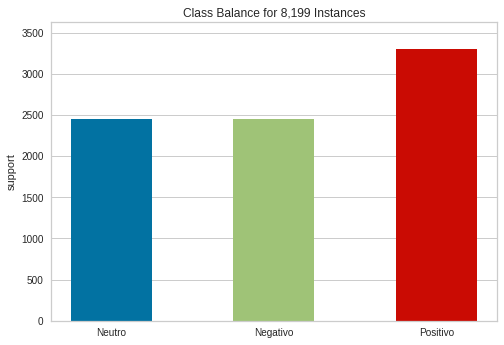

In [23]:
from yellowbrick import ClassBalance

#Instanciar
Grafico_balanco = ClassBalance(labels = ['Neutro', 'Negativo', 'Positivo'])
Grafico_balanco.fit(Base_dados['Classificacao'])
Grafico_balanco.show();

In [29]:
#Plot auxiliar
Analise_valores = Base_dados['Classificacao'].value_counts()

#plotly
Grafico_balanco02 = go.Figure(
    go.Funnelarea(
        text = Analise_valores.index,
        values = Analise_valores.values,
        title = {'text': 'Distribuicao dos sentimentos', 'position' : 'top center'}
    )
)

Grafico_balanco02.show()

## 2-  Quantidade de palavras

In [30]:
def Quantidade_palavras(texto):
    Quebrar = texto.split()
    Quantidade = len(Quebrar)
    return Quantidade

Base_dados['Quantidade_palavras'] = Base_dados['Text'].apply(Quantidade_palavras)
#verificando
Base_dados.head()

Created At  \
0  Sun Jan 08 01:22:05 +0000 2017   
1  Sun Jan 08 01:49:01 +0000 2017   
2  Sun Jan 08 01:01:46 +0000 2017   
3  Wed Jan 04 21:43:51 +0000 2017   
4  Mon Jan 09 15:08:21 +0000 2017   

                                                Text  \
0  ���⛪ @ Catedral de Santo Antônio - Governador ...   
1  � @ Governador Valadares, Minas Gerais https:/...   
2  �� @ Governador Valadares, Minas Gerais https:...   
3                        ��� https://t.co/BnDsO34qK0   
4  ��� PSOL vai questionar aumento de vereadores ...   

   Geo Coordinates.latitude  Geo Coordinates.longitude User Location  \
0                       NaN                        NaN        Brasil   
1                  -41.9333                     -18.85           NaN   
2                  -41.9333                     -18.85           NaN   
3                       NaN                        NaN           NaN   
4                       NaN                        NaN           NaN   

               Username User Screen Name  Retweet Count Classificacao  \
0  Leonardo C Schneider    LeoCSchneider              0        Neutro   
1               Wândell         klefnews              0        Neutro   
2               Wândell         klefnews              0        Neutro   
3         Ana estudando  estudandoconcur              0        Neutro   
4                 Emily         Milly777              0      Negativo   

   Quantidade_palavras  
0                   10  
1                    7  
2                    7  
3                    2  
4                   20

In [32]:
Base_dados['Quantidade_palavras'].describe()

count    8199.000000
mean       16.141115
std         4.280192
min         1.000000
25%        13.000000
50%        15.000000
75%        19.000000
max        32.000000
Name: Quantidade_palavras, dtype: float64

In [33]:
#plot

px.box(Base_dados, x = 'Classificacao', y = 'Quantidade_palavras', color= 'Classificacao', title = 'Quantidade de palavras por sentimento')

## 3 - Nuvem de palavras

In [49]:
import wordcloud

In [37]:
#criando uma wordcloud
#concatenar o texto em uma unica variavel
Concatenar = ''
#loop no texto
for texto in Base_dados['Text']:
    # Loop para concatenar
    for palavra in texto.split():
        #juntando as palavras
        Concatenar = Concatenar + ' ' + palavra

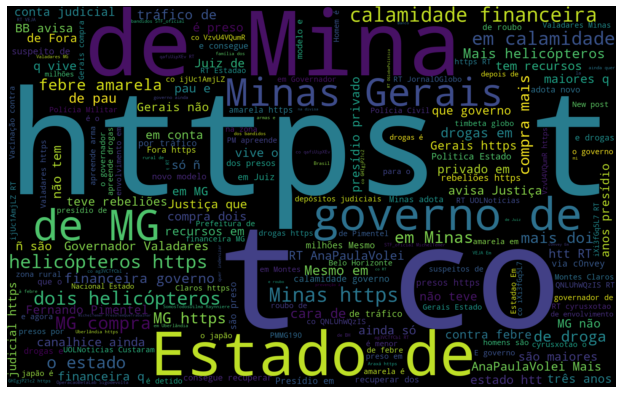

In [39]:
#Plot da nuvem de palavras
Nuvem_palavras = wordcloud.WordCloud(width = 1600, height = 1000).generate(Concatenar)

#Tamanho
Figura, Eixo =  plt.subplots(figsize = (15,7))
#plot
Eixo.imshow(Nuvem_palavras, interpolation = 'bilinear')
Eixo.set_axis_off()

In [44]:
#Gerar nuvem de palavras para cada sentimento
#Ajuste dos textos
Palavras_positivas = ''
Palavras_negativas = ''
Palavras_neutras = ''

#loop
for sentimento in Base_dados['Classificacao'].unique():
    
    #1o sentimento = positivo
    if sentimento == 'Positivo':
        filtro =  Base_dados.loc[Base_dados['Classificacao'] == sentimento]
        
        #loop para concatenar
        for palavra in filtro['Text']:
            for quebra in palavra.split():
                Palavras_positivas = Palavras_positivas + ' ' + quebra
                
    #2o sentimento = negativo
    elif sentimento == 'Negativo':
        filtro =  Base_dados.loc[Base_dados['Classificacao'] == sentimento]
        
        #loop para concatenar
        for palavra in filtro['Text']:
            for quebra in palavra.split():
                Palavras_negativas = Palavras_negativas + ' ' + quebra
                
    #3o sentimento =  neutro
    else:
        filtro =  Base_dados.loc[Base_dados['Classificacao'] == sentimento]
        
        #loop para concatenar
        for palavra in filtro['Text']:
            for quebra in palavra.split():
                Palavras_neutras = Palavras_neutras + ' ' + quebra

In [45]:
print(
    'Quantidade de palavras: \n',
    f'Positivo: {len(Palavras_positivas)}',
    f'Negativo: {len(Palavras_negativas)}',
    f'Neutro: {len(Palavras_neutras)}'
)

Quantidade de palavras: 
 Positivo: 374456 Negativo: 307576 Neutro: 279383


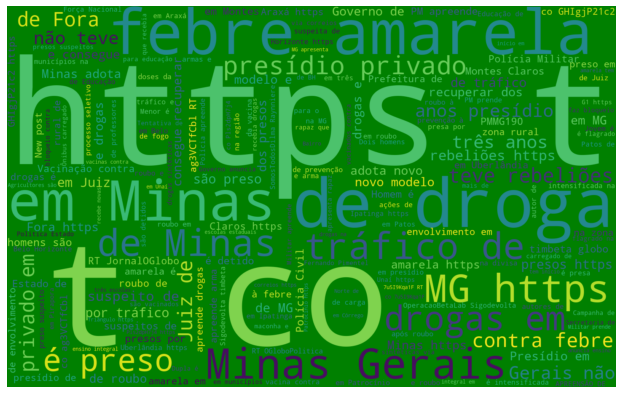

In [46]:
#Criando a nuvem de palavras pro sentimento positivo
#Plot da nuvem de palavras
Nuvem_palavras = wordcloud.WordCloud(width = 1600, height = 1000, background_color = 'green').generate(Palavras_positivas)

#Tamanho
Figura, Eixo =  plt.subplots(figsize = (15,7))
#plot
Eixo.imshow(Nuvem_palavras, interpolation = 'bilinear')
Eixo.set_axis_off()

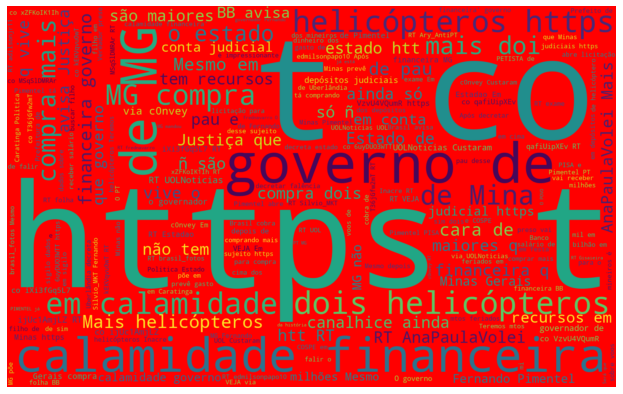

In [47]:
#Plot da nuvem de palavras
Nuvem_palavras = wordcloud.WordCloud(width = 1600, height = 1000,background_color='red').generate(Palavras_negativas)

#Tamanho
Figura, Eixo =  plt.subplots(figsize = (15,7))
#plot
Eixo.imshow(Nuvem_palavras, interpolation = 'bilinear')
Eixo.set_axis_off()

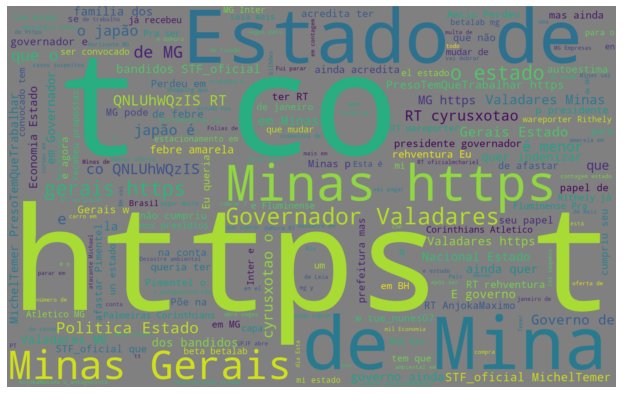

In [48]:
#Plot da nuvem de palavras
Nuvem_palavras = wordcloud.WordCloud(width = 1600, height = 1000, background_color='gray').generate(Palavras_neutras)

#Tamanho
Figura, Eixo =  plt.subplots(figsize = (15,7))
#plot
Eixo.imshow(Nuvem_palavras, interpolation = 'bilinear')
Eixo.set_axis_off()

## 4 - Ranking das palavras mais usadas

In [49]:
from collections import Counter

In [50]:
#Quebrar as frases
Quebra_frases = Base_dados['Text'].apply(lambda Texto: str(Texto).split())

#Rank de palavras
Dados_rank = Counter([item for sublist in Quebra_frases for item in sublist ])

#Tabela
Tab_quantidade = pd.DataFrame(Dados_rank.most_common(20))

#Ajustar as colunas
Tab_quantidade.columns = ['Palavra','Quantidade']


In [52]:
#plot
figura = px.bar(
    Tab_quantidade,
    x = 'Quantidade',
    y = 'Palavra',
    color = 'Palavra',
    orientation = 'h',
    width = 700,
    height = 700
)
figura.show()

# Mineração de texto

In [26]:
#antes
print(Base_dados.shape)
Copia_base = Base_dados.copy()
#retirar textos duplicados
Base_dados.drop_duplicates(['Text'],inplace = True)
print(Base_dados.shape)

(8199, 9)
(5765, 9)


In [55]:
#verificar stopwords
nltk.corpus.stopwords.words('portuguese')[:20]

['a',
 'à',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as',
 'às',
 'até',
 'com',
 'como',
 'da',
 'das',
 'de',
 'dela',
 'delas',
 'dele']

In [57]:
#REGEX

Frase_exemplo = 'Acessei o site do google https:\\www.google.com.br e achei simples'
re.findall('www',Frase_exemplo)

['www']

# Limpeza dos dados
## Precisamos retirar:
### 1 - Emojis
### 2 - Caracteres especiais
### 3 - Links, hashtags

In [22]:
#retirando links
exemplo = Base_dados['Text'][6]
exemplo

re.sub('https:\S+','',exemplo)

'"..E 25% dos mineiros dizem não torcer para time nenhum,mesmo dentro de um estado com Atlético-MG e Cruzeiro. Pq?.." '

In [ ]:
#converter pra minusculo
exemplo.lower()

In [9]:
#caracteres especiais
re.sub('["("")"?@|$|.|!,:%;"]','',exemplo)

'E 25 dos mineiros dizem não torcer para time nenhummesmo dentro de um estado com Atlético-MG e Cruzeiro Pq https//tco/fN5evlLQsR'

In [17]:
#retirar emojis
  # Retirar Emojis
Retirar_Emojis = re.compile(
    "["
    u"\U0001F600-\U0001F64F"  # Emojis
    u"\U0001F300-\U0001F5FF"  # Simbolos
    u"\U0001F680-\U0001F6FF" 
    u"\U0001F1E0-\U0001F1FF"  
    u"\U0001F1F2-\U0001F1F4"  
    u"\U0001F1E6-\U0001F1FF" 
    u"\U0001F600-\U0001F64F"
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u"\U0001F1F2"
    u"\U0001F1F4"
    u"\U0001F620"
    u"\u200d"
    u"\u2640-\u2642"
    "]+", flags=re.UNICODE
)
Retirar_Emojis.sub('',exemplo)

' @ Catedral de Santo Antônio - Governador Valadares/MG https://t.co/JSbKamIqUJ'

In [ ]:
#retirar hashtag
re.sub('#\S+', '', exemplo) #\S+ quer dizer tudo que vier depois do símbolo

In [23]:
#retirar numeros
re.sub('[0-9]','',exemplo)

'"..E % dos mineiros dizem não torcer para time nenhum,mesmo dentro de um estado com Atlético-MG e Cruzeiro. Pq?.." https://t.co/fNevlLQsR'

In [24]:
def limpeza_dados(texto):
    '''
    Função para limpar os dados
    '''
    #retirar os links
    Camada_01 = re.sub('https:\S+','',texto)
    #retirando para minúsculo
    Camada_02 = Camada_01.lower()
    #retirar caracteres especiais, @, # %
    Camada_03 = re.sub('["("")"?@|$|.|!,:%;"]','',Camada_02)
    #retirar emojis
    Retirar_Emojis = re.compile(
    "["
    u"\U0001F600-\U0001F64F"  # Emojis
    u"\U0001F300-\U0001F5FF"  # Simbolos
    u"\U0001F680-\U0001F6FF" 
    u"\U0001F1E0-\U0001F1FF"  
    u"\U0001F1F2-\U0001F1F4"  
    u"\U0001F1E6-\U0001F1FF" 
    u"\U0001F600-\U0001F64F"
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u"\U0001F1F2"
    u"\U0001F1F4"
    u"\U0001F620"
    u"\u200d"
    u"\u2640-\u2642"
    "]+", flags=re.UNICODE)
    Camada_04 = Retirar_Emojis.sub('',Camada_03)
    #retirar hashtag
    Camada_05 = re.sub('#\S+', '', Camada_04)
    #retirar caracteres numericos
    Camada_06 = re.sub('[0-9]','',Camada_05)
    
    return Camada_06

## Remoção de stopwords

In [27]:
#separar os dados
Dados_modelo = Base_dados[['Text','Classificacao']]
Dados_modelo.shape

(5765, 2)

In [28]:
#aplicando a funcao
Dados_modelo['Text_limpo'] = Dados_modelo['Text'].apply(limpeza_dados)
Dados_modelo.head()

Text Classificacao  \
0  ���⛪ @ Catedral de Santo Antônio - Governador ...        Neutro   
1  � @ Governador Valadares, Minas Gerais https:/...        Neutro   
2  �� @ Governador Valadares, Minas Gerais https:...        Neutro   
3                        ��� https://t.co/BnDsO34qK0        Neutro   
4  ��� PSOL vai questionar aumento de vereadores ...      Negativo   

                                          Text_limpo  
0    catedral de santo antônio - governador valad...  
1                 governador valadares minas gerais   
2                 governador valadares minas gerais   
3                                                     
4   psol vai questionar aumento de vereadores e p...

In [29]:
#pool de palavras
Grupo_palavras = nltk.corpus.stopwords.words('portuguese')
len(Grupo_palavras)

207

In [30]:
def remover_stopwords(texto):
    
    '''
    Remover palavras que não são importantes para a análise
    '''
    #Quebrar as frases
    Lista_palavras = texto.split()
    
    #nova frase
    Frase_ajustada =''
    
    for palavra in Lista_palavras:
        if palavra not in Grupo_palavras:
            Frase_ajustada = Frase_ajustada + ' ' + palavra
            
    return Frase_ajustada

In [32]:
Dados_modelo['Text_limpo'] = Dados_modelo['Text_limpo'].apply(remover_stopwords)
Dados_modelo.head()

Text Classificacao  \
0  ���⛪ @ Catedral de Santo Antônio - Governador ...        Neutro   
1  � @ Governador Valadares, Minas Gerais https:/...        Neutro   
2  �� @ Governador Valadares, Minas Gerais https:...        Neutro   
3                        ��� https://t.co/BnDsO34qK0        Neutro   
4  ��� PSOL vai questionar aumento de vereadores ...      Negativo   

                                          Text_limpo  
0   catedral santo antônio - governador valadares/mg  
1                  governador valadares minas gerais  
2                  governador valadares minas gerais  
3                                                     
4   psol vai questionar aumento vereadores prefei...

Agora vamos refazer as nuvens de palavras no texto tratado e ver a diferença


In [44]:
#aplicando a funcao de limpeza de dados
Dados_modelo['Text_limpo2'] = Dados_modelo['Text'].apply(limpeza_dados)
Dados_modelo.head()

Text Classificacao  \
0  ���⛪ @ Catedral de Santo Antônio - Governador ...        Neutro   
1  � @ Governador Valadares, Minas Gerais https:/...        Neutro   
2  �� @ Governador Valadares, Minas Gerais https:...        Neutro   
3                        ��� https://t.co/BnDsO34qK0        Neutro   
4  ��� PSOL vai questionar aumento de vereadores ...      Negativo   

                                          Text_limpo  \
0           catedr sant antôni - govern valadares/mg   
1                             govern valad min geral   
2                             govern valad min geral   
3                                                      
4   psol vai quest aument vere prefeit bh justiç ...   

                                         Text_limpo2  
0    catedral de santo antônio - governador valad...  
1                 governador valadares minas gerais   
2                 governador valadares minas gerais   
3                                                     
4   psol vai questionar aumento de vereadores e p...

In [45]:
Dados_modelo['Text_limpo2'] = Dados_modelo['Text_limpo2'].apply(remover_stopwords)
Dados_modelo.head()

Text Classificacao  \
0  ���⛪ @ Catedral de Santo Antônio - Governador ...        Neutro   
1  � @ Governador Valadares, Minas Gerais https:/...        Neutro   
2  �� @ Governador Valadares, Minas Gerais https:...        Neutro   
3                        ��� https://t.co/BnDsO34qK0        Neutro   
4  ��� PSOL vai questionar aumento de vereadores ...      Negativo   

                                          Text_limpo  \
0           catedr sant antôni - govern valadares/mg   
1                             govern valad min geral   
2                             govern valad min geral   
3                                                      
4   psol vai quest aument vere prefeit bh justiç ...   

                                         Text_limpo2  
0   catedral santo antônio - governador valadares/mg  
1                  governador valadares minas gerais  
2                  governador valadares minas gerais  
3                                                     
4   psol vai questionar aumento vereadores prefei...

In [47]:
#Gerar nuvem de palavras para cada sentimento
#Ajuste dos textos
Palavras_positivas = ''
Palavras_negativas = ''
Palavras_neutras = ''

#loop
for sentimento in Dados_modelo['Classificacao'].unique():
    
    #1o sentimento = positivo
    if sentimento == 'Positivo':
        filtro =  Dados_modelo.loc[Dados_modelo['Classificacao'] == sentimento]
        
        #loop para concatenar
        for palavra in filtro['Text_limpo2']:
            for quebra in palavra.split():
                Palavras_positivas = Palavras_positivas + ' ' + quebra
                
    #2o sentimento = negativo
    elif sentimento == 'Negativo':
        filtro =  Dados_modelo.loc[Dados_modelo['Classificacao'] == sentimento]
        
        #loop para concatenar
        for palavra in filtro['Text_limpo2']:
            for quebra in palavra.split():
                Palavras_negativas = Palavras_negativas + ' ' + quebra
                
    #3o sentimento =  neutro
    else:
        filtro =  Dados_modelo.loc[Dados_modelo['Classificacao'] == sentimento]
        
        #loop para concatenar
        for palavra in filtro['Text_limpo2']:
            for quebra in palavra.split():
                Palavras_neutras = Palavras_neutras + ' ' + quebra

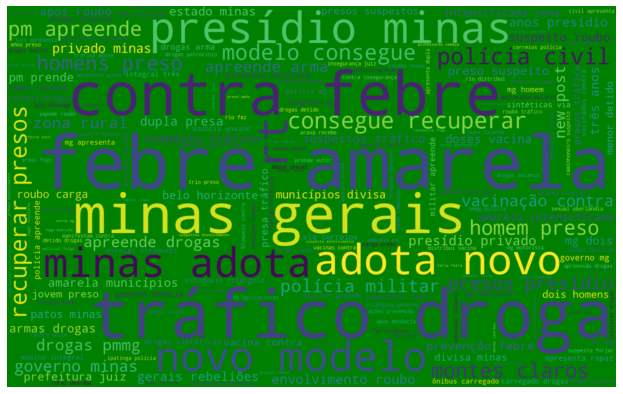

In [50]:
#Wordcloud positiva

#Plot da nuvem de palavras
Nuvem_palavras = wordcloud.WordCloud(width = 1600, height = 1000, background_color = 'green').generate(Palavras_positivas)

#Tamanho
Figura, Eixo =  plt.subplots(figsize = (15,7))
#plot
Eixo.imshow(Nuvem_palavras, interpolation = 'bilinear')
Eixo.set_axis_off()

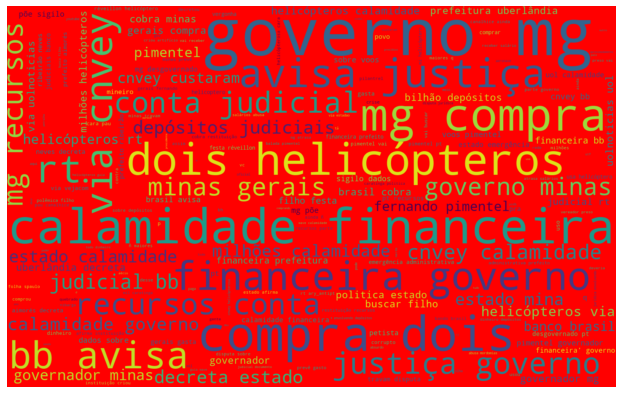

In [51]:
#Wordcloud negativa
#Plot da nuvem de palavras
Nuvem_palavras = wordcloud.WordCloud(width = 1600, height = 1000,background_color='red').generate(Palavras_negativas)

#Tamanho
Figura, Eixo =  plt.subplots(figsize = (15,7))
#plot
Eixo.imshow(Nuvem_palavras, interpolation = 'bilinear')
Eixo.set_axis_off()

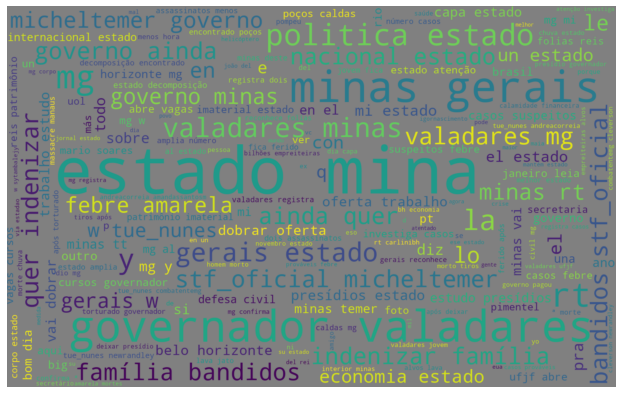

In [52]:
#Wordcloud neutra
Nuvem_palavras = wordcloud.WordCloud(width = 1600, height = 1000, background_color='gray').generate(Palavras_neutras)

#Tamanho
Figura, Eixo =  plt.subplots(figsize = (15,7))
#plot
Eixo.imshow(Nuvem_palavras, interpolation = 'bilinear')
Eixo.set_axis_off()

## Extração de radical

In [33]:
#definir a função que extrai o radical
Radical = nltk.stem.RSLPStemmer()

In [35]:
def extrair_radical(texto):
    '''
    Extrair radical da palavra
    
    '''
    
    #Quebra
    Lista_palavras = texto.split()
    
    #Nova frase
    Frase_ajustada = ''
    
    #loop
    for palavra in Lista_palavras:
        
        #aplicar o radical 
        Extracao = Radical.stem(palavra)
        Frase_ajustada = Frase_ajustada + ' ' + Extracao
        
    return Frase_ajustada
    

In [36]:
extrair_radical(exemplo)

' ".. 25% do min diz não torc par tim nenhum,mesm dentr de um est com atlético-mg e cruzeiro. pq?.." https://t.co/fn5evllqsr'

In [37]:
Dados_modelo['Text_limpo'] = Dados_modelo['Text_limpo'].apply(extrair_radical)
Dados_modelo.head()

Text Classificacao  \
0  ���⛪ @ Catedral de Santo Antônio - Governador ...        Neutro   
1  � @ Governador Valadares, Minas Gerais https:/...        Neutro   
2  �� @ Governador Valadares, Minas Gerais https:...        Neutro   
3                        ��� https://t.co/BnDsO34qK0        Neutro   
4  ��� PSOL vai questionar aumento de vereadores ...      Negativo   

                                          Text_limpo  
0           catedr sant antôni - govern valadares/mg  
1                             govern valad min geral  
2                             govern valad min geral  
3                                                     
4   psol vai quest aument vere prefeit bh justiç ...

## Tokenização

In [38]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/isabel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [40]:
from nltk.tokenize import word_tokenize

# Modelo

In [42]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import train_test_split

In [43]:
#Separar
Frases = Dados_modelo['Text_limpo']
Classes = Dados_modelo['Classificacao']

#dividir 
X_train, X_test, y_train, y_test = train_test_split(Frases, Classes, test_size = 0.2, random_state=10)

In [53]:
#Instanciar o método
Token = TweetTokenizer()
Vetorizacao = CountVectorizer(analyzer = 'word',tokenizer = Token.tokenize)

In [55]:
#Aplicando a transformação
Frequencia_palavras =  Vetorizacao.fit_transform(X_train)


## Construção do modelo


Vamos utilisar o modelo Naive Bayes, um modelo de classificação supervisionada. Ele funciona classificando os dados em positivo/negativo.

In [56]:
#importar o modelo
from sklearn.naive_bayes import MultinomialNB

In [58]:
#Instanciando o modelo
Modelo_NB = MultinomialNB()

#Treinamento
Modelo_NB.fit(Frequencia_palavras,y_train)

MultinomialNB()

## Avaliação do modelo

In [59]:
#Transformacao do X_teste
Vetor_x_teste = Vetorizacao.transform(X_test)

#Fazendo a previsão
Previsoes = Modelo_NB.predict(Vetor_x_teste)

In [60]:
#Vamos fazer a avaliação do desempenho do modelo através de uma matriz de confusão
from sklearn.metrics import confusion_matrix

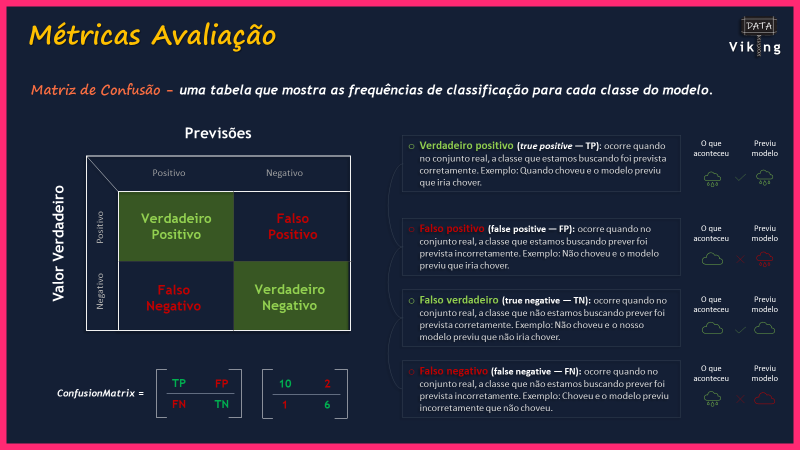

<AxesSubplot:>

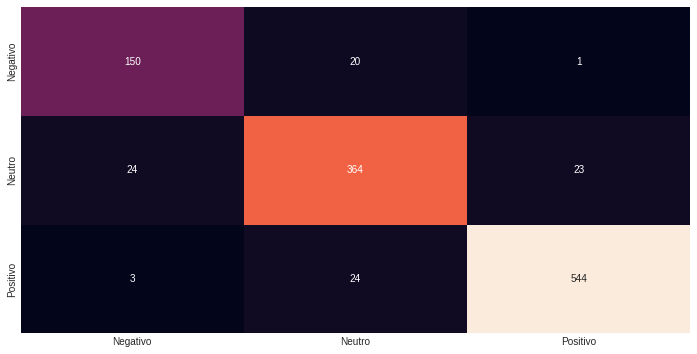

In [64]:
#plot
Matriz_confusao = confusion_matrix(y_test,Previsoes)

Classes =['Negativo', 'Neutro','Positivo']

sns.heatmap(Matriz_confusao, annot = True, cbar = False, fmt = 'd',yticklabels = Classes,xticklabels = Classes)

In [65]:
#Relatorio de classificação
from sklearn.metrics import classification_report

#Avaliação
Avaliacao = classification_report(y_test,Previsoes)
print(Avaliacao)

              precision    recall  f1-score   support

    Negativo       0.85      0.88      0.86       171
      Neutro       0.89      0.89      0.89       411
    Positivo       0.96      0.95      0.96       571

    accuracy                           0.92      1153
   macro avg       0.90      0.91      0.90      1153
weighted avg       0.92      0.92      0.92      1153



## Teste do modelo


In [76]:
escrevendo_tweet = input('O que está pensando?')

print(escrevendo_tweet)

O que está pensando?O governo entrou em calamidade financeira.
O governo entrou em calamidade financeira.


In [74]:
def consolidar_funcoes(texto):
    #1a etapa
    Limpeza = limpeza_dados(texto)
    
    #2a etapa
    Stop = remover_stopwords(Limpeza)
    
    #3a etapa
    Rad = extrair_radical(Stop)
    
    #4a etapa
    Vet = Vetorizacao.transform([Rad])
    
    #5a etapa
    Previsao = Modelo_NB.predict(Vet)
    
    return Previsao

In [77]:
print(f'O sentimento da frase é o seguinte: {consolidar_funcoes(escrevendo_tweet)[0]}')

O sentimento da frase é o seguinte: Negativo


## Testando outros modelos de classificação

In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [80]:
Algoritimos = [
    LogisticRegression(),
    RandomForestClassifier(n_estimators = 300, max_depth =12),
    MultinomialNB(),
    SVC()
]

#Nomes
Lista_nome = ['Regressão logística','Random Forests', 'Naive Bayes', 'Vetor de máquinas'] 

In [84]:
#Lista de acurácias
Resultado_acuracia = []

#loop
for nome, modelo in zip(Lista_nome,Algoritimos):
    
    Alg = modelo
    Alg.fit(Frequencia_palavras,y_train)
    
    #Transformar os dados de teste
    Vetor_teste = Vetorizacao.transform(X_test)
    
    #Previsão com os modelos
    Previsoes_teste = Alg.predict(Vetor_teste)
    
    #Resultado
    Resultado = accuracy_score(y_test,Previsoes_teste)
    
    #Salvar
    Resultado_acuracia.append(Resultado) 

In [86]:
#Organizar
Dicionario = {
    'Nome' : Lista_nome,
    'Resultado' : Resultado_acuracia
}

pd.DataFrame(Dicionario).sort_values('Resultado',ascending = False)

Nome  Resultado
3    Vetor de máquinas   0.947962
0  Regressão logística   0.942758
2          Naive Bayes   0.917606
1       Random Forests   0.887251